In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import matplotlib.pyplot as plt
import sys
import os
# import warnings
# warnings.filterwarnings('ignore')

#user = 'madams01'
#sys.path.append(f'/home/{user}/git_clones/copymltox/ml-tox/src')
sys.path.append("/home/ishah/ipynb/ml-tox/src")
from sklearn.linear_model import LogisticRegression
from mltox.db.mongo import *
from mltox.db.bc import *
from mltox.db.bio import *
from mltox.db.graph_utils import *

import functools
import seaborn as sns

Skipped loading some Jax models, missing a dependency. No module named 'haiku'


# Data

In [3]:
P_old = P0 = pd.read_csv("/home/ishah/ipynb/ml-tox/data/res/ATG_Output_model_performances.csv").drop('Unnamed: 0',axis=1)
P_old.head()
PosFrac = P_old.iloc[3:,[0,3]]
PosFrac

,Assay,% positive
3,ATG_AP_1_CIS,33.20
4,ATG_AP_2_CIS,17.75
5,ATG_AR_TRANS,7.31
6,ATG_Ahr_CIS,37.03
7,ATG_BRE_CIS,27.73
...,...,...
80,ATG_VDRE_CIS,42.23
81,ATG_VDR_TRANS,9.41
82,ATG_Xbp1_CIS,25.78
83,ATG_p53_CIS,25.32


# Performance

In [47]:
RES="/home/ishah/ipynb/ml-tox/data/res/"

In [6]:
P0 = pd.read_csv("/home/ishah/ipynb/ml-tox/data/res/atg_model_performances_12_19.csv")#.drop('Unnamed: 0',axis=1)
#C0 = P0.columns[:3]
#C0
P0

,Unnamed: 0,ROC-AUC,ROC-AUC.1,ROC-AUC.2,ROC-AUC.3,ROC-AUC.4,ROC-AUC.5,ROC-AUC.6,ROC-AUC.7,ROC-AUC.8,ROC-AUC.9,ROC-AUC.10,ROC-AUC.11,ROC-AUC.12,ROC-AUC.13,ROC-AUC.14,ROC-AUC.15,ROC-AUC.16,ROC-AUC.17
0,Model,Attentive-FP,Attentive-FP,GCN,GCN,GenRA,GenRA,Gradient Boost,Gradient Boost,Logistic Regression,Logistic Regression,Multi-Task NN,Multi-Task NN,Random Forest,Random Forest,Single-Task NN,Single-Task NN,Weave,Weave
1,NaN,mean,std,mean,std,mean,std,mean,std,mean,std,mean,std,mean,std,mean,std,mean,std
2,Assay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ATG_AP_1_CIS,0.764790371616976,0.018018519008034053,0.7217436534953527,0.026336983072597783,0.6824187845200776,0.021630487704027014,0.6963542666282814,0.02828250285264491,0.6754646215853113,0.015548041379604268,0.7048576043653443,0.017848204010431738,0.7186646327810121,0.0218574105762646,0.672831999178982,0.015911635226984588,0.7210821653883053,0.021215193049708748
4,ATG_AP_2_CIS,0.7211964871341948,0.019893301394633096,0.7093294951721123,0.016306451455907454,0.6580330746489282,0.02592539441997561,0.6722073658049268,0.022259565248302214,0.6020012507817386,0.028798005931535624,0.6597032213700091,0.03052301014049636,0.6767944453920063,0.02101563756890285,0.5781811430439479,0.03025537965604079,0.6772847150759251,0.026277143776406806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,ATG_THRa1_TRANS,0.6966889408299821,0.028140618862020766,0.6707910985572954,0.013276087566215426,0.592706658807559,0.019885009422692983,0.6424833249128609,0.01961366373809524,0.5888958846854571,0.028096824394465595,0.661135390271435,0.02653712690758187,0.6441279962847855,0.02053239273812979,0.5608786125102705,0.026111256746898796,0.6790768500096469,0.02675182166986736
79,ATG_VDRE_CIS,0.7857390449987396,0.015473734161924197,0.7602235065088239,0.010590083386971413,0.7121590157259912,0.015389900442242298,0.7196246507152914,0.018744547533161605,0.7234988633857532,0.015800484643840963,0.7450861450636446,0.015503099654624921,0.7480761319490389,0.017413978985923423,0.7211627606154681,0.017555309676553207,0.7410894619302361,0.024702877593296015
80,ATG_VDR_TRANS,0.6889328494242674,0.04140324424774841,0.6003288678640978,0.026538878793548923,0.6026800976800977,0.02803841786407719,0.6019152276295133,0.027524642493792387,0.5683998778998779,0.03357791646147031,0.6382575017255816,0.030689640692344134,0.60968894993895,0.021156959582165548,0.5313119658119658,0.04369706151944043,0.6550865044444714,0.034111378649254155
81,ATG_Xbp1_CIS,0.7443626491196942,0.023182314214032305,0.7191017047507344,0.031093372086377517,0.6650375146160842,0.018754823820821095,0.671507374549144,0.02255575582891391,0.6333847602962193,0.017798149880580545,0.6851556960542451,0.02014516407852781,0.7049524165259192,0.011294591081765238,0.6265429442206921,0.021592764941732887,0.6954777479931851,0.016136403887224003


In [5]:
I = [0]
for i,v in enumerate(P0.iloc[1].tolist()):
    print(i,v)
    if v=='mean':
        I.append(i)
P0.iloc[0,I]

0 nan
1 mean
2 std
3 mean
4 std
5 mean
6 std
7 mean
8 std
9 mean
10 std
11 mean
12 std
13 mean
14 std
15 mean
16 std
17 mean
18 std


Unnamed: 0                  Model
ROC-AUC              Attentive-FP
ROC-AUC.2                     GCN
ROC-AUC.4                   GenRA
ROC-AUC.6          Gradient Boost
ROC-AUC.8     Logistic Regression
ROC-AUC.10          Multi-Task NN
ROC-AUC.12          Random Forest
ROC-AUC.14         Single-Task NN
ROC-AUC.16                  Weave
Name: 0, dtype: object

In [43]:
3*(162/2773)

0.17526144969347277

In [20]:
P0

,Unnamed: 0,ROC-AUC,ROC-AUC.1,ROC-AUC.2,ROC-AUC.3,ROC-AUC.4,ROC-AUC.5,ROC-AUC.6,ROC-AUC.7,ROC-AUC.8,ROC-AUC.9,ROC-AUC.10,ROC-AUC.11,ROC-AUC.12,ROC-AUC.13,ROC-AUC.14,ROC-AUC.15,ROC-AUC.16,ROC-AUC.17
0,Model,Attentive-FP,Attentive-FP,GCN,GCN,GenRA,GenRA,Gradient Boost,Gradient Boost,Logistic Regression,Logistic Regression,Multi-Task NN,Multi-Task NN,Random Forest,Random Forest,Single-Task NN,Single-Task NN,Weave,Weave
1,NaN,mean,std,mean,std,mean,std,mean,std,mean,std,mean,std,mean,std,mean,std,mean,std
2,Assay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ATG_AP_1_CIS,0.764790371616976,0.018018519008034053,0.7217436534953527,0.026336983072597783,0.6824187845200776,0.021630487704027014,0.6963542666282814,0.02828250285264491,0.6754646215853113,0.015548041379604268,0.7048576043653443,0.017848204010431738,0.7186646327810121,0.0218574105762646,0.672831999178982,0.015911635226984588,0.7210821653883053,0.021215193049708748
4,ATG_AP_2_CIS,0.7211964871341948,0.019893301394633096,0.7093294951721123,0.016306451455907454,0.6580330746489282,0.02592539441997561,0.6722073658049268,0.022259565248302214,0.6020012507817386,0.028798005931535624,0.6597032213700091,0.03052301014049636,0.6767944453920063,0.02101563756890285,0.5781811430439479,0.03025537965604079,0.6772847150759251,0.026277143776406806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,ATG_THRa1_TRANS,0.6966889408299821,0.028140618862020766,0.6707910985572954,0.013276087566215426,0.592706658807559,0.019885009422692983,0.6424833249128609,0.01961366373809524,0.5888958846854571,0.028096824394465595,0.661135390271435,0.02653712690758187,0.6441279962847855,0.02053239273812979,0.5608786125102705,0.026111256746898796,0.6790768500096469,0.02675182166986736
79,ATG_VDRE_CIS,0.7857390449987396,0.015473734161924197,0.7602235065088239,0.010590083386971413,0.7121590157259912,0.015389900442242298,0.7196246507152914,0.018744547533161605,0.7234988633857532,0.015800484643840963,0.7450861450636446,0.015503099654624921,0.7480761319490389,0.017413978985923423,0.7211627606154681,0.017555309676553207,0.7410894619302361,0.024702877593296015
80,ATG_VDR_TRANS,0.6889328494242674,0.04140324424774841,0.6003288678640978,0.026538878793548923,0.6026800976800977,0.02803841786407719,0.6019152276295133,0.027524642493792387,0.5683998778998779,0.03357791646147031,0.6382575017255816,0.030689640692344134,0.60968894993895,0.021156959582165548,0.5313119658119658,0.04369706151944043,0.6550865044444714,0.034111378649254155
81,ATG_Xbp1_CIS,0.7443626491196942,0.023182314214032305,0.7191017047507344,0.031093372086377517,0.6650375146160842,0.018754823820821095,0.671507374549144,0.02255575582891391,0.6333847602962193,0.017798149880580545,0.6851556960542451,0.02014516407852781,0.7049524165259192,0.011294591081765238,0.6265429442206921,0.021592764941732887,0.6954777479931851,0.016136403887224003


In [7]:
P1 = P0.iloc[3:-1,I]
C1 = ['Assay'] + P0.iloc[0,I[1:]].tolist()
P1.columns=C1
P1

,Assay,Attentive-FP,GCN,GenRA,Gradient Boost,Logistic Regression,Multi-Task NN,Random Forest,Single-Task NN,Weave
3,ATG_AP_1_CIS,0.764790371616976,0.7217436534953527,0.6824187845200776,0.6963542666282814,0.6754646215853113,0.7048576043653443,0.7186646327810121,0.672831999178982,0.7210821653883053
4,ATG_AP_2_CIS,0.7211964871341948,0.7093294951721123,0.6580330746489282,0.6722073658049268,0.6020012507817386,0.6597032213700091,0.6767944453920063,0.5781811430439479,0.6772847150759251
5,ATG_AR_TRANS,0.6625771460311751,0.6167482783212417,0.5885253014249179,0.5628588391878491,0.5640710632078918,0.6303104642316966,0.586561472415053,0.5237760321519913,0.6316818339231093
6,ATG_Ahr_CIS,0.6597119362465819,0.6307632855391503,0.605924080095233,0.6211885852363439,0.5897970968143134,0.6266209897038483,0.6228752465220404,0.5929212639695823,0.6022467540203215
7,ATG_BRE_CIS,0.7469666190289004,0.7093902676553245,0.6563419895547344,0.6898696848431588,0.6577389922176579,0.7002986509053759,0.6961941095720744,0.6473818456742977,0.6995059772218857
...,...,...,...,...,...,...,...,...,...,...
77,ATG_TGFb_CIS,0.626294037249612,0.6001982137363632,0.5435724137931034,0.5416475593372145,0.5516210031347962,0.5690009979441469,0.5634838557993731,0.5398184952978057,0.6138091607354902
78,ATG_THRa1_TRANS,0.6966889408299821,0.6707910985572954,0.592706658807559,0.6424833249128609,0.5888958846854571,0.661135390271435,0.6441279962847855,0.5608786125102705,0.6790768500096469
79,ATG_VDRE_CIS,0.7857390449987396,0.7602235065088239,0.7121590157259912,0.7196246507152914,0.7234988633857532,0.7450861450636446,0.7480761319490389,0.7211627606154681,0.7410894619302361
80,ATG_VDR_TRANS,0.6889328494242674,0.6003288678640978,0.6026800976800977,0.6019152276295133,0.5683998778998779,0.6382575017255816,0.60968894993895,0.5313119658119658,0.6550865044444714


In [8]:
P1pp = P1.merge(PosFrac,on='Assay')

In [9]:
D1 = {'Assay': 'ATG',
 'Attentive-FP': 'AFP',
 'GCN': 'GCN',
 'GenRA': 'GenRA',
 'Gradient Boost': 'GB',
 'Logistic Regression': 'LR',
 'Multi-Task NN': 'MTNN',
 'Random Forest': 'RF',
 'Single-Task NN': 'STNN',
 'Weave': 'Weave'}

            

P1 = P1.rename(columns=D1).set_index('ATG')
for y in P1.columns:
    P1[y] = P1[y].astype(np.float32)

In [21]:
P1

,STNN,LR,GenRA,GB,RF,MTNN,GCN,Weave,AFP
ATG,,,,,,,,,
ATG_AP_1_CIS,0.672832,0.675465,0.682419,0.696354,0.718665,0.704858,0.721744,0.721082,0.764790
ATG_AP_2_CIS,0.578181,0.602001,0.658033,0.672207,0.676794,0.659703,0.709329,0.677285,0.721196
ATG_AR_TRANS,0.523776,0.564071,0.588525,0.562859,0.586562,0.630310,0.616748,0.631682,0.662577
ATG_Ahr_CIS,0.592921,0.589797,0.605924,0.621189,0.622875,0.626621,0.630763,0.602247,0.659712
ATG_BRE_CIS,0.647382,0.657739,0.656342,0.689870,0.696194,0.700299,0.709390,0.699506,0.746967
...,...,...,...,...,...,...,...,...,...
ATG_TGFb_CIS,0.539818,0.551621,0.543572,0.541648,0.563484,0.569001,0.600198,0.613809,0.626294
ATG_THRa1_TRANS,0.560879,0.588896,0.592707,0.642483,0.644128,0.661135,0.670791,0.679077,0.696689
ATG_VDRE_CIS,0.721163,0.723499,0.712159,0.719625,0.748076,0.745086,0.760224,0.741089,0.785739


In [10]:
Mn1 = P1.mean(axis=0)
P1.dtypes

AFP      float32
GCN      float32
GenRA    float32
GB       float32
LR       float32
MTNN     float32
RF       float32
STNN     float32
Weave    float32
dtype: object

In [24]:
Mn1.round(decimals=2).sort_values(ascending=False)

AFP      0.71
GCN      0.67
Weave    0.67
MTNN     0.66
RF       0.66
GB       0.64
GenRA    0.62
LR       0.61
STNN     0.59
dtype: float32

In [11]:
J1 = P1.mean().sort_values().index

In [12]:
I1 = P1.mean(axis=1).sort_values().index
I1

Index(['ATG_M_61_TRANS', 'ATG_M_19_TRANS', 'ATG_M_06_TRANS', 'ATG_M_19_CIS',
       'ATG_M_32_TRANS', 'ATG_M_61_CIS', 'ATG_M_06_CIS', 'ATG_STAT3_CIS',
       'ATG_TGFb_CIS', 'ATG_RORg_TRANS', 'ATG_AR_TRANS', 'ATG_LXRb_TRANS',
       'ATG_LXRa_TRANS', 'ATG_M_32_CIS', 'ATG_RXRa_TRANS', 'ATG_GATA_CIS',
       'ATG_HIF1a_CIS', 'ATG_FoxA2_CIS', 'ATG_PPARd_TRANS', 'ATG_VDR_TRANS',
       'ATG_Myb_CIS', 'ATG_Ahr_CIS', 'ATG_GLI_CIS', 'ATG_FoxO_CIS',
       'ATG_GRE_CIS', 'ATG_ERRa_TRANS', 'ATG_GR_TRANS', 'ATG_ERRg_TRANS',
       'ATG_E2F_CIS', 'ATG_Ets_CIS', 'ATG_HNF4a_TRANS', 'ATG_RARb_TRANS',
       'ATG_THRa1_TRANS', 'ATG_RORb_TRANS', 'ATG_RXRb_TRANS',
       'ATG_NURR1_TRANS', 'ATG_HNF6_CIS', 'ATG_TAL_CIS', 'ATG_CAR_TRANS',
       'ATG_Sox_CIS', 'ATG_CRE_CIS', 'ATG_FXR_TRANS', 'ATG_RARa_TRANS',
       'ATG_RARg_TRANS', 'ATG_AP_2_CIS', 'ATG_HSE_CIS', 'ATG_Myc_CIS',
       'ATG_NRF1_CIS', 'ATG_NFI_CIS', 'ATG_E_Box_CIS', 'ATG_NF_kB_CIS',
       'ATG_TCF_b_cat_CIS', 'ATG_IR1_CIS', 'ATG_Sp1_CIS

In [13]:
import re
SelAssay=[i for i in I1 if re.search(r'ROR|AR|LXR|RXR|ER|Ahr|PXR|PPAR|CAR|FXR',i)]
SelAssay1=[i for i in I1 if re.search(r'NF_|Xbp1|NRF|p53|ROR|AR|LXR|RXR|ER|Ahr|PXR|PPAR|CAR|FXR',i)]
SelAssay

['ATG_RORg_TRANS',
 'ATG_AR_TRANS',
 'ATG_LXRb_TRANS',
 'ATG_LXRa_TRANS',
 'ATG_RXRa_TRANS',
 'ATG_PPARd_TRANS',
 'ATG_Ahr_CIS',
 'ATG_ERRa_TRANS',
 'ATG_ERRg_TRANS',
 'ATG_RARb_TRANS',
 'ATG_RORb_TRANS',
 'ATG_RXRb_TRANS',
 'ATG_CAR_TRANS',
 'ATG_FXR_TRANS',
 'ATG_RARa_TRANS',
 'ATG_RARg_TRANS',
 'ATG_ERE_CIS',
 'ATG_DR5_RAR_CIS',
 'ATG_PXRE_CIS',
 'ATG_PPARa_TRANS',
 'ATG_ERa_TRANS',
 'ATG_RORE_CIS',
 'ATG_DR4_LXR_CIS',
 'ATG_PXR_TRANS',
 'ATG_NRF2_ARE_CIS',
 'ATG_PPARg_TRANS']

In [14]:
print('\n'.join(SelAssay))

ATG_RORg_TRANS
ATG_AR_TRANS
ATG_LXRb_TRANS
ATG_LXRa_TRANS
ATG_RXRa_TRANS
ATG_PPARd_TRANS
ATG_Ahr_CIS
ATG_ERRa_TRANS
ATG_ERRg_TRANS
ATG_RARb_TRANS
ATG_RORb_TRANS
ATG_RXRb_TRANS
ATG_CAR_TRANS
ATG_FXR_TRANS
ATG_RARa_TRANS
ATG_RARg_TRANS
ATG_ERE_CIS
ATG_DR5_RAR_CIS
ATG_PXRE_CIS
ATG_PPARa_TRANS
ATG_ERa_TRANS
ATG_RORE_CIS
ATG_DR4_LXR_CIS
ATG_PXR_TRANS
ATG_NRF2_ARE_CIS
ATG_PPARg_TRANS


In [15]:
P1 =P1[J1]

In [16]:
P2 = P1.reset_index().melt(id_vars='ATG',var_name='ML',value_name='ROC')

/opt/miniconda3/envs/dl/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0.5, 'AUC ROC')]

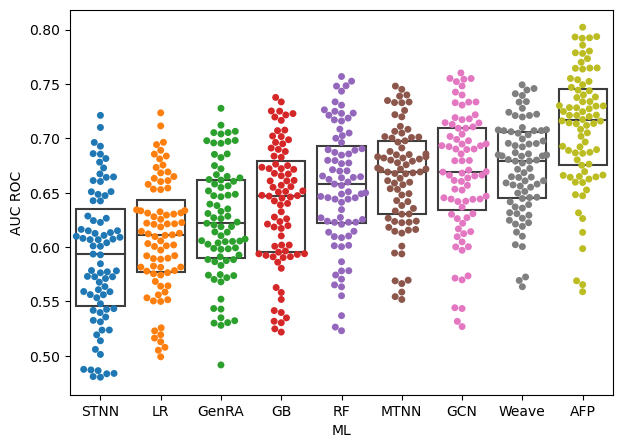

In [17]:
import pylab as pl
fig = pl.figure(figsize=(7,5))
ax = pl.subplot(1,1,1)
sns.boxplot(x='ML',y='ROC',order=J1,data=P2,
            showcaps=False,boxprops={'facecolor':'None'},
             showfliers=False,whiskerprops={'linewidth':0},
             )
g = sns.swarmplot(x='ML',y='ROC',order=J1,data=P2)
g.set(ylabel='AUC ROC')

In [73]:
#sns.catplot(x='ML',y='ROC',data=P2,kind='boxen',aspect=1.2,height=5)

In [25]:
P2['ATG']=pd.Categorical(P2['ATG'],categories=I1,ordered=True)

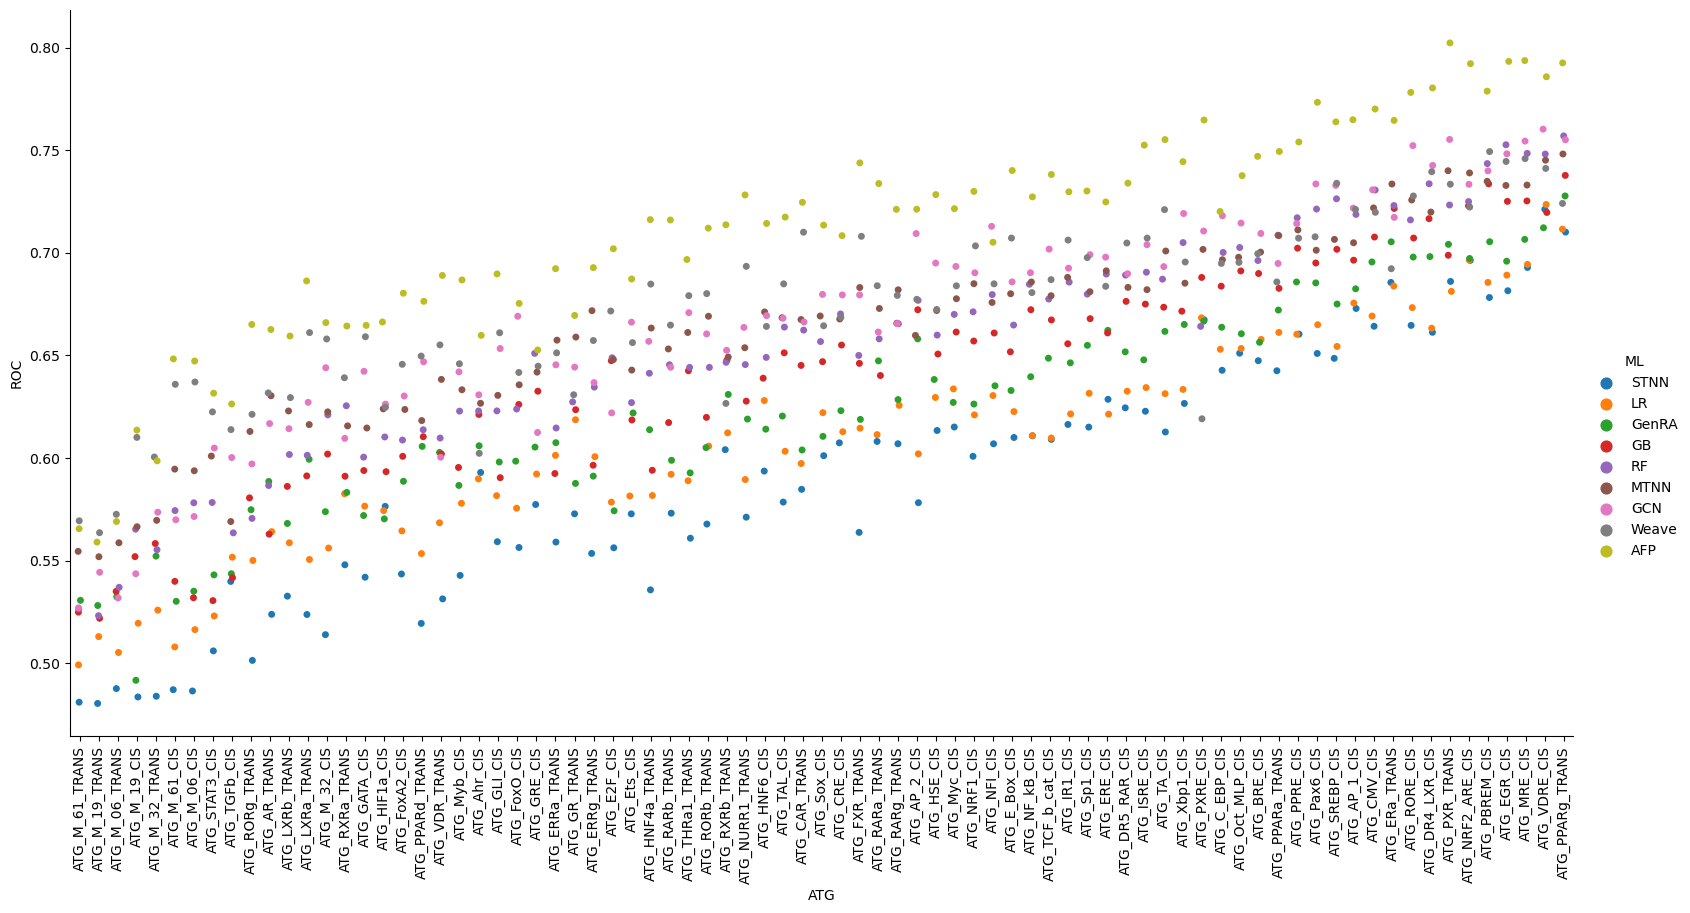

In [26]:
g=sns.catplot(x='ATG',y='ROC',hue='ML',data=P2,n_boot=0,
              aspect=2,height=8)
g.set_xticklabels(rotation=90)

In [27]:
P3 = pd.DataFrame(P2[P2.ATG.isin(SelAssay)].to_dict('records'))
I3 = P3.groupby('ATG').aggregate(dict(ROC=np.mean)).sort_values('ROC').index
I3

Index(['ATG_RORg_TRANS', 'ATG_AR_TRANS', 'ATG_LXRb_TRANS', 'ATG_LXRa_TRANS',
       'ATG_RXRa_TRANS', 'ATG_PPARd_TRANS', 'ATG_Ahr_CIS', 'ATG_ERRa_TRANS',
       'ATG_ERRg_TRANS', 'ATG_RARb_TRANS', 'ATG_RORb_TRANS', 'ATG_RXRb_TRANS',
       'ATG_CAR_TRANS', 'ATG_FXR_TRANS', 'ATG_RARa_TRANS', 'ATG_RARg_TRANS',
       'ATG_ERE_CIS', 'ATG_DR5_RAR_CIS', 'ATG_PXRE_CIS', 'ATG_PPARa_TRANS',
       'ATG_ERa_TRANS', 'ATG_RORE_CIS', 'ATG_DR4_LXR_CIS', 'ATG_PXR_TRANS',
       'ATG_NRF2_ARE_CIS', 'ATG_PPARg_TRANS'],
      dtype='object', name='ATG')

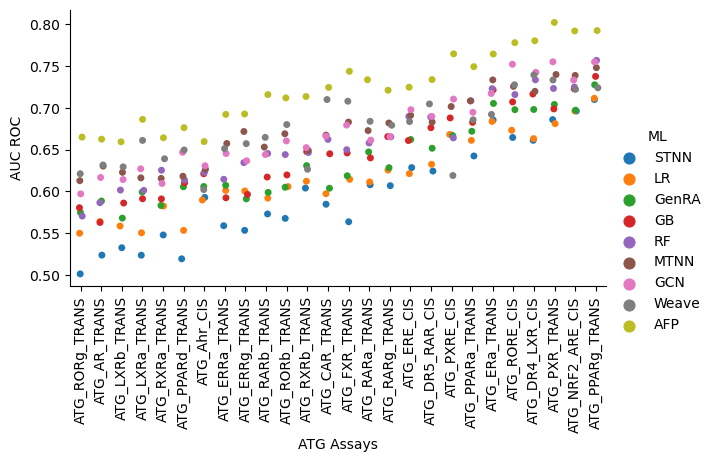

In [28]:
P3['ATG']=pd.Categorical(P3['ATG'],categories=I3,ordered=True)
g=sns.catplot(x='ATG',y='ROC',hue='ML',data=P3,n_boot=0,
              aspect=1.8,height=3.5)
g.set_xticklabels(rotation=90)
g.set(ylabel='AUC ROC',xlabel='ATG Assays')

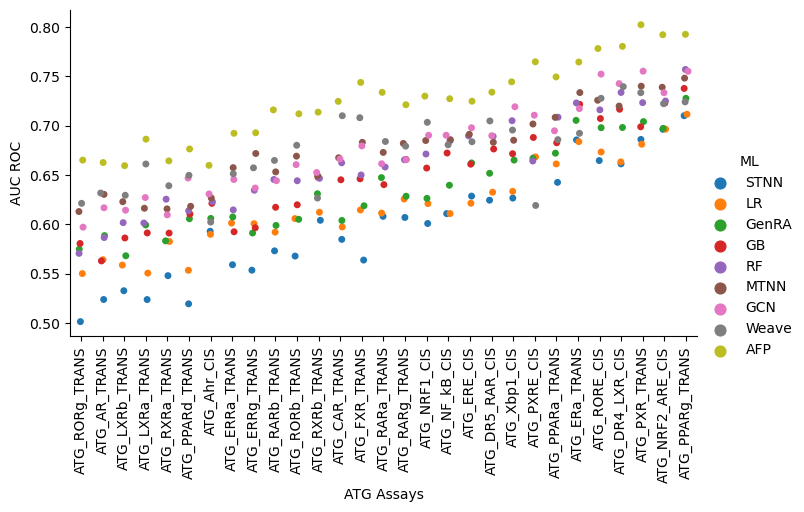

In [29]:
P3b = pd.DataFrame(P2[P2.ATG.isin(SelAssay1)].to_dict('records'))
I3b = P3b.groupby('ATG').aggregate(dict(ROC=np.mean)).sort_values('ROC').index
P3b['ATG']=pd.Categorical(P3b['ATG'],categories=I3b,ordered=True)
g=sns.catplot(x='ATG',y='ROC',hue='ML',data=P3b,n_boot=0,
              aspect=1.8,height=4)
g.set_xticklabels(rotation=90)
g.set(ylabel='AUC ROC',xlabel='ATG Assays')

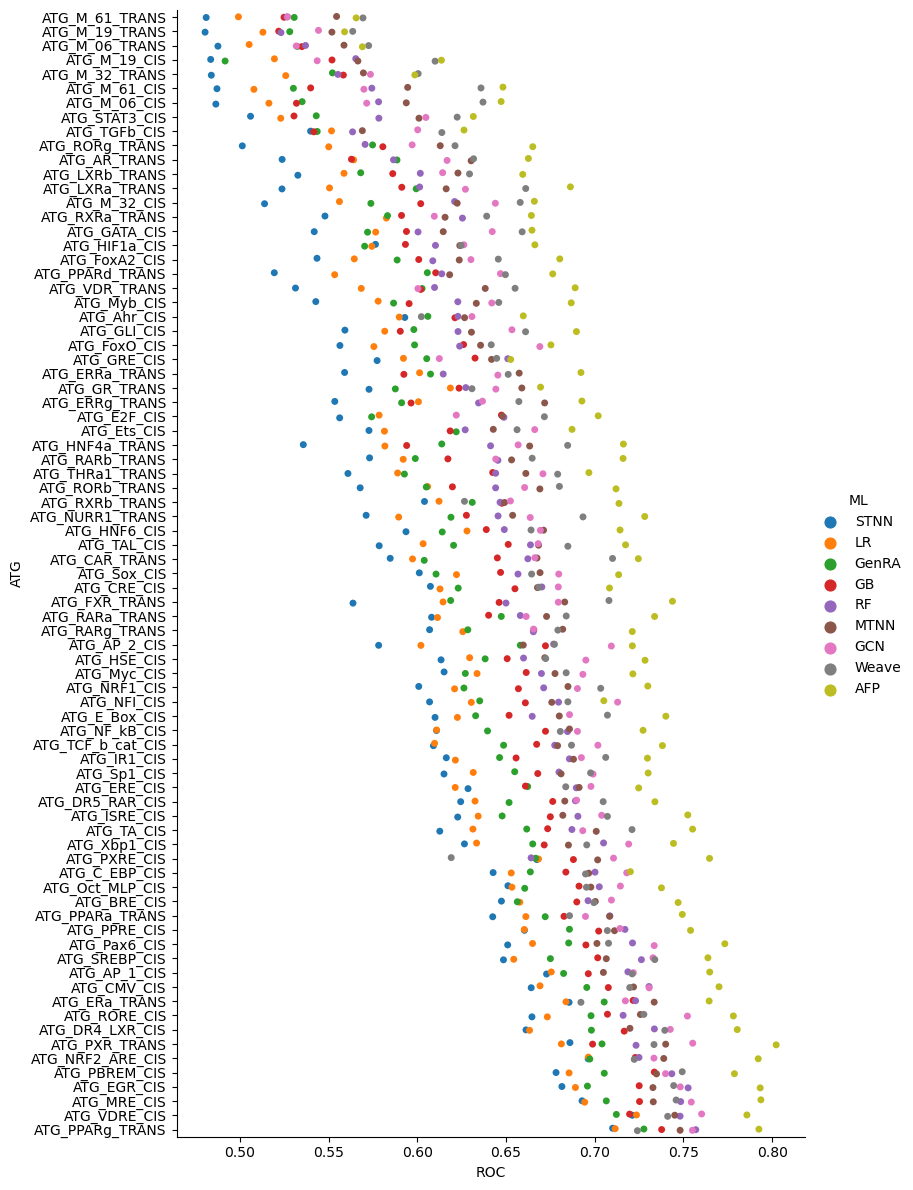

In [30]:
g=sns.catplot(y='ATG',x='ROC',hue='ML',data=P2,n_boot=0,
              aspect=0.7,height=12)
#g.set_xticklabels(rotation=90)

In [31]:
P2.ML

0      STNN
1      STNN
2      STNN
3      STNN
4      STNN
       ... 
706     AFP
707     AFP
708     AFP
709     AFP
710     AFP
Name: ML, Length: 711, dtype: object

In [32]:
P2.ML.unique()

array(['STNN', 'LR', 'GenRA', 'GB', 'RF', 'MTNN', 'GCN', 'Weave', 'AFP'],
      dtype=object)

In [33]:
P2.insert(0,'SM',P2.ML.apply(lambda i: 'ST' if i in ['LR','GenRA','GB','STNN'] else 'MT'))

<AxesSubplot:xlabel='ROC', ylabel='Count'>

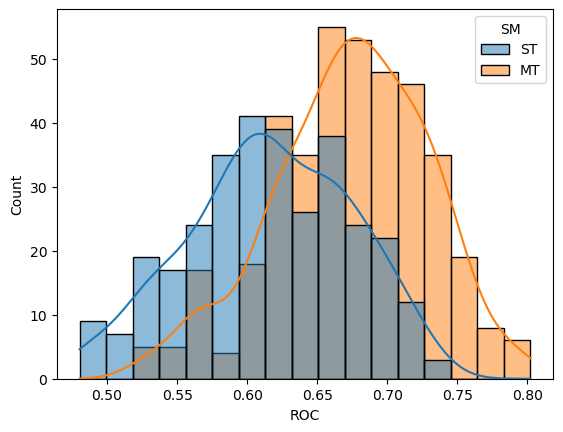

In [34]:
sns.histplot(data=P2,x='ROC',hue='SM',kde=True)

In [37]:
P2

,SM,ATG,ML,ROC
0,ST,ATG_AP_1_CIS,STNN,0.672832
1,ST,ATG_AP_2_CIS,STNN,0.578181
2,ST,ATG_AR_TRANS,STNN,0.523776
3,ST,ATG_Ahr_CIS,STNN,0.592921
4,ST,ATG_BRE_CIS,STNN,0.647382
...,...,...,...,...
706,MT,ATG_TGFb_CIS,AFP,0.626294
707,MT,ATG_THRa1_TRANS,AFP,0.696689
708,MT,ATG_VDRE_CIS,AFP,0.785739
709,MT,ATG_VDR_TRANS,AFP,0.688933


In [38]:
P2.sort_values('ROC',ascending=False).head(10)

,SM,ATG,ML,ROC
689,MT,ATG_PXR_TRANS,AFP,0.802238
666,MT,ATG_MRE_CIS,AFP,0.793634
644,MT,ATG_EGR_CIS,AFP,0.793237
686,MT,ATG_PPARg_TRANS,AFP,0.792499
680,MT,ATG_NRF2_ARE_CIS,AFP,0.792117
708,MT,ATG_VDRE_CIS,AFP,0.785739
641,MT,ATG_DR4_LXR_CIS,AFP,0.780311
683,MT,ATG_PBREM_CIS,AFP,0.778733
694,MT,ATG_RORE_CIS,AFP,0.778112
690,MT,ATG_Pax6_CIS,AFP,0.773300


In [39]:
P2.sort_values('ROC',ascending=False).tail(10)

,SM,ATG,ML,ROC
64,ST,ATG_RORg_TRANS,STNN,0.501338
121,ST,ATG_M_61_TRANS,LR,0.499149
195,ST,ATG_M_19_CIS,GenRA,0.491645
36,ST,ATG_M_06_TRANS,STNN,0.487600
41,ST,ATG_M_61_CIS,STNN,0.487060
35,ST,ATG_M_06_CIS,STNN,0.486428
40,ST,ATG_M_32_TRANS,STNN,0.483872
37,ST,ATG_M_19_CIS,STNN,0.483520
42,ST,ATG_M_61_TRANS,STNN,0.480974
38,ST,ATG_M_19_TRANS,STNN,0.480360


In [40]:
P3.sort_values('ROC',ascending=False).tail(10)

,ATG,ML,ROC
7,ATG_ERRg_TRANS,STNN,0.553466
40,ATG_PPARd_TRANS,LR,0.553402
36,ATG_LXRa_TRANS,LR,0.550512
49,ATG_RORg_TRANS,LR,0.550041
24,ATG_RXRa_TRANS,STNN,0.547928
11,ATG_LXRb_TRANS,STNN,0.532651
0,ATG_AR_TRANS,STNN,0.523776
10,ATG_LXRa_TRANS,STNN,0.523707
14,ATG_PPARd_TRANS,STNN,0.519367
23,ATG_RORg_TRANS,STNN,0.501338


In [41]:
P2.to_excel('/home/ishah/ipynb/ml-tox/data/res/bio-ml-perf-3.xlsx')

In [26]:
P2.ML.value_counts()

STNN     79
LR       79
GenRA    79
GB       79
RF       79
MTNN     79
GCN      79
Weave    79
AFP      79
Name: ML, dtype: int64

In [27]:
P2.sort_values('ROC',ascending=False)

,ATG,ML,ROC
689,ATG_PXR_TRANS,AFP,0.802238
666,ATG_MRE_CIS,AFP,0.793634
644,ATG_EGR_CIS,AFP,0.793237
686,ATG_PPARg_TRANS,AFP,0.792499
680,ATG_NRF2_ARE_CIS,AFP,0.792117
...,...,...,...
35,ATG_M_06_CIS,STNN,0.486428
40,ATG_M_32_TRANS,STNN,0.483872
37,ATG_M_19_CIS,STNN,0.483520
42,ATG_M_61_TRANS,STNN,0.480974


In [42]:
P2.sort_values('ROC',ascending=False)

,SM,ATG,ML,ROC
689,MT,ATG_PXR_TRANS,AFP,0.802238
666,MT,ATG_MRE_CIS,AFP,0.793634
644,MT,ATG_EGR_CIS,AFP,0.793237
686,MT,ATG_PPARg_TRANS,AFP,0.792499
680,MT,ATG_NRF2_ARE_CIS,AFP,0.792117
...,...,...,...,...
35,ST,ATG_M_06_CIS,STNN,0.486428
40,ST,ATG_M_32_TRANS,STNN,0.483872
37,ST,ATG_M_19_CIS,STNN,0.483520
42,ST,ATG_M_61_TRANS,STNN,0.480974


In [81]:
Pi = P2[P2.ATG=='ATG_PPARg_TRANS'].sort_values('ROC',ascending=False)
', '.join(Pi.apply(lambda i: "{ML}/{ROC:.2f}".format(**i.to_dict()),axis=1))

'AFP/0.79, RF/0.76, GCN/0.76, MTNN/0.75, GB/0.74, GenRA/0.73, Weave/0.72, LR/0.71, STNN/0.71'

In [89]:
Pi = P2[P2.ATG=='ATG_ERa_TRANS'].sort_values('ROC',ascending=False)
print(', '.join(Pi.apply(lambda i: "{ML}/{ROC:.2f}".format(**i.to_dict()),axis=1)))

AFP/0.76, MTNN/0.73, RF/0.72, GB/0.72, GCN/0.72, GenRA/0.71, Weave/0.69, STNN/0.69, LR/0.68


In [83]:
Pi = P2[P2.ATG=='ATG_AR_TRANS'].sort_values('ROC',ascending=False)
', '.join(Pi.apply(lambda i: "{ML}/{ROC:.2f}".format(**i.to_dict()),axis=1))

'AFP/0.66, Weave/0.63, MTNN/0.63, GCN/0.62, GenRA/0.59, RF/0.59, LR/0.56, GB/0.56, STNN/0.52'

In [43]:
X = P2.groupby('ATG').aggregate(dict(ROC=np.mean)).sort_values('ROC',ascending=False)
X.head(10)

,ROC
ATG,
ATG_PPARg_TRANS,0.740389
ATG_VDRE_CIS,0.739629
ATG_MRE_CIS,0.732682
ATG_EGR_CIS,0.729193
ATG_PBREM_CIS,0.727638
ATG_NRF2_ARE_CIS,0.724910
ATG_PXR_TRANS,0.724891
ATG_DR4_LXR_CIS,0.717211
ATG_RORE_CIS,0.715840


In [94]:
Pi = P2[(P2.ML=='AFP')].sort_values('ROC',ascending=False)
Pi.ROC.mean(),Pi[Pi.ATG.str.contains('ERa')]
#print(', '.join(Pi.apply(lambda i: "{ML}/{ROC:.2f}".format(**i.to_dict()),axis=1)))

(0.7100342512130737,
      SM            ATG   ML       ROC
 648  MT  ATG_ERa_TRANS  AFP  0.764462)

In [45]:
P1pp[['Assay','% positive']].dropna()

,Assay,% positive
0,ATG_AP_1_CIS,33.20
1,ATG_AP_2_CIS,17.75
2,ATG_AR_TRANS,7.31
3,ATG_Ahr_CIS,37.03
4,ATG_BRE_CIS,27.73
...,...,...
74,ATG_TGFb_CIS,20.86
75,ATG_THRa1_TRANS,13.43
76,ATG_VDRE_CIS,42.23
77,ATG_VDR_TRANS,9.41


In [84]:
X = P1pp[['Assay','% positive']].dropna()\
        .rename(columns={'% positive':'pos_pcnt','Assay':'ATG'})\
        .sort_values('pos_pcnt',ascending=False)
X

,ATG,pos_pcnt
56,ATG_PXRE_CIS,69.85
48,ATG_NRF2_ARE_CIS,53.45
57,ATG_PXR_TRANS,46.98
13,ATG_ERE_CIS,46.46
76,ATG_VDRE_CIS,42.23
...,...,...
36,ATG_M_06_TRANS,7.85
42,ATG_M_61_TRANS,7.83
2,ATG_AR_TRANS,7.31
14,ATG_ERRa_TRANS,7.28


In [48]:
X.to_excel(RES+'/ml-bio-1-pos-frac.xlsx')

In [85]:
P4 = P2.merge(X,on='ATG')

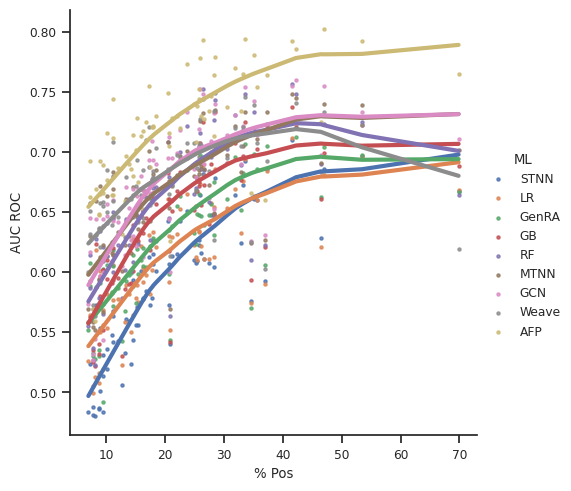

In [86]:
g=sns.lmplot(data=P4,x='pos_pcnt',y='ROC',hue='ML',
             fit_reg=True,lowess=True,scatter=True,
             height=5,
             scatter_kws=dict(s=5),
            line_kws=dict(lw=3))
g.set(xlabel='% Pos',ylabel='AUC ROC')

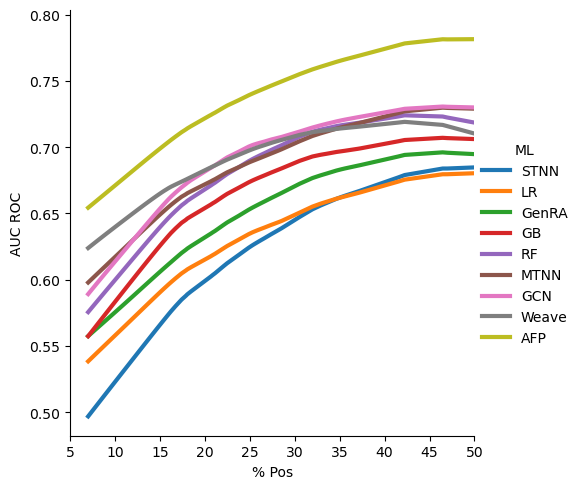

In [51]:
g=sns.lmplot(data=P4,x='pos_pcnt',y='ROC',hue='ML',
             fit_reg=True,lowess=True,scatter=False,
             height=5,
             scatter_kws=dict(s=5),
            line_kws=dict(lw=3))
g.set(xlim=[5,50],xlabel='% Pos',ylabel='AUC ROC')

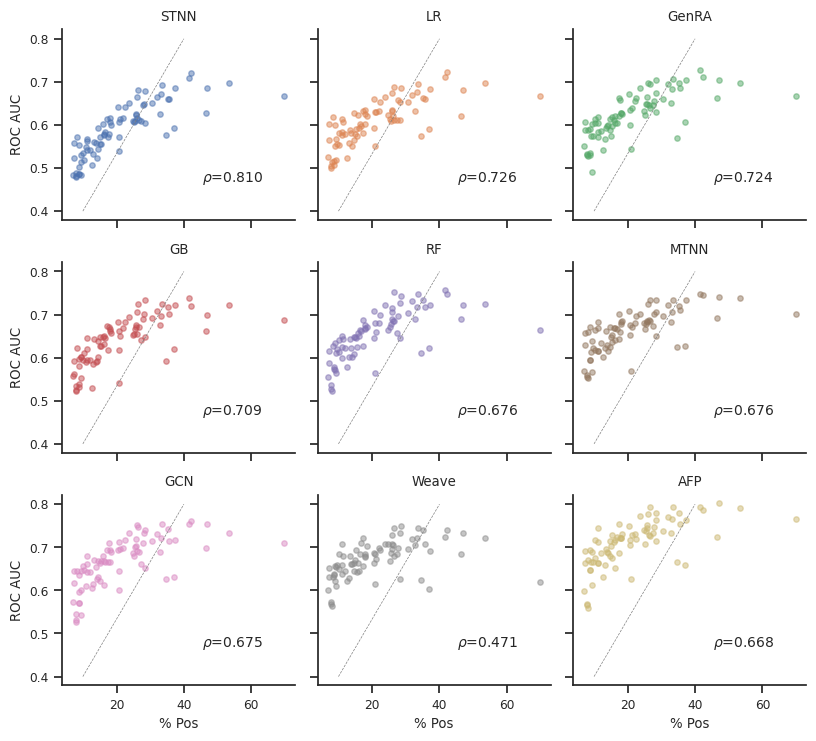

In [52]:
from sklearn.metrics import r2_score
import scipy as sp
def mycorr(x, y, **kws):
    nna = x.notna() & y.notna()
    r,p= sp.stats.pearsonr(x[nna], y[nna])
    return r
    
def corrfunc(x, y, **kws):
    nna = x.notna() & y.notna()
    r,p = sp.stats.pearsonr(x[nna], y[nna])
    ax = plt.gca()
    # ax.annotate(r"$\rho$={:.2f}".format(r)+r"({:.2f})".format(p),
    #             xy=(.6, .2), size=10,
    #             xycoords=ax.transAxes)
    ax.annotate(r"$\rho$={:.3f}".format(r),
                xy=(.6, .2), size=10,
                xycoords=ax.transAxes)

def mr2_score(x,y, **kws):
    nna = x.notna() & y.notna()
    r = r2_score(np.log10(x[nna]), np.log10(y[nna]))
    ax = plt.gca()
    ax.annotate(r"$R^2$={:.2f}".format(r),
                xy=(.6, .1), size=10,
                xycoords=ax.transAxes)


# Draw
sns.set(font_scale=0.8,style='ticks')

g=sns.FacetGrid(P4,col='ML',col_wrap=3,
                height=2.5,aspect=1.1,
                hue='ML',
                legend_out=True)
A,B = 'pos_pcnt','ROC'
g.map(pl.scatter,A,B,s=15,alpha=0.5)
g.map(corrfunc,A,B)
#g.map(mr2_score,A,B)
g.map_dataframe(pl.plot,[10,40],[0.4,0.8],'--',linewidth=0.5,color='grey')#,linestyle='--')#,linewidth=0.5,color='grey')
g.set_titles(row_template='{row_name}',col_template='{col_name}')
#g.set(xscale='log',yscale='log',xlim=[1e-1,1e2],ylim=[1e-1,1e3])
g.set(xlabel=r'% Pos',
      ylabel=r'ROC AUC')

g.fig.tight_layout()

In [87]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Performing two-way ANOVA
# The model considers both the ML approach and the percentage of positive chemicals as factors

# For two-way ANOVA, we need to have both the factors and the response (ROC) in the same dataframe
# Creating the model formula for two-way ANOVA
model_formula = 'ROC ~ C(ML) + pos_pcnt + C(ML):pos_pcnt'

# Fitting the model
model = ols(model_formula, data=P4).fit()

# Performing the ANOVA test
anova_results = sm.stats.anova_lm(model, typ=2)

anova_results


,sum_sq,df,F,PR(>F)
C(ML),0.831576,8.0,70.401215,1.981205e-84
pos_pcnt,0.939935,1.0,636.598883,3.850614e-100
C(ML):pos_pcnt,0.037733,8.0,3.194487,1.435421e-03
Residual,1.023211,693.0,NaN,NaN


In [88]:
# Creating a DataFrame for the percentage difference in mean ROC AUC score between each pair of ML methods
mean_roc_by_ml = P4.groupby('ML').aggregate(dict(ROC=np.mean)).sort_values("ROC")
ml_methods = mean_roc_by_ml.index
percentage_diff_matrix = pd.DataFrame(index=ml_methods, columns=ml_methods,dtype=np.float32)

# Calculating the percentage difference in mean ROC AUC for each pair
for method_i in ml_methods:
    for method_j in ml_methods:
        roc_i = mean_roc_by_ml.loc[method_i].ROC
        roc_j = mean_roc_by_ml.loc[method_j].ROC
        percentage_diff = ((roc_i - roc_j) / roc_j) * 100  # Percentage difference formula
        percentage_diff_matrix.at[method_i, method_j] = percentage_diff

X0=percentage_diff_matrix.round(decimals=1)


<AxesSubplot:xlabel='ML', ylabel='ML'>

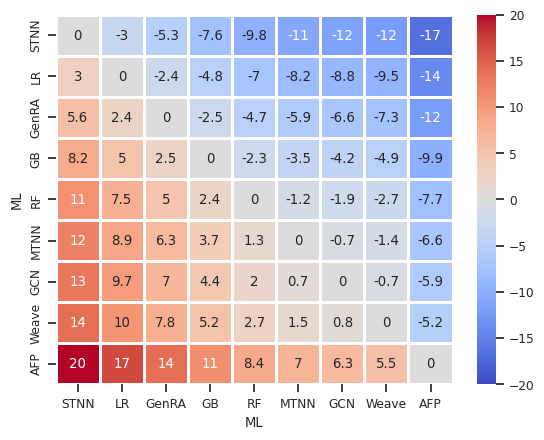

In [62]:
sns.heatmap(X0,vmin=-20,vmax=20,lw=1,annot=True,cmap='coolwarm')

In [63]:
from scipy.stats import ttest_ind
# Creating a DataFrame to store the statistical significance of performance differences between each pair of ML methods
significance_matrix = pd.DataFrame(index=ml_methods, columns=ml_methods)
alpha=0.001

# Performing t-tests to determine statistical significance for each pair
for method_i in ml_methods:
    for method_j in ml_methods:
        if method_i != method_j:
            subset_i = P4[P4['ML'] == method_i]['ROC']
            subset_j = P4[P4['ML'] == method_j]['ROC']
            t_stat, p_value = ttest_ind(subset_i, subset_j, equal_var=False)
            significance = '*' if p_value < alpha else ''
        else:
            significance = ''  # No comparison needed for the same method
        significance_matrix.at[method_i, method_j] = significance

significance_matrix


ML,STNN,LR,GenRA,GB,RF,MTNN,GCN,Weave,AFP
ML,,,,,,,,,
STNN,,,*,*,*,*,*,*,*
LR,,,,*,*,*,*,*,*
GenRA,*,,,,*,*,*,*,*
GB,*,*,,,,,,*,*
RF,*,*,*,,,,,,*
MTNN,*,*,*,,,,,,*
GCN,*,*,*,,,,,,*
Weave,*,*,*,*,,,,,*
AFP,*,*,*,*,*,*,*,*,


In [71]:
X = percentage_diff_matrix.round(decimals=1).applymap(lambda i:"{:2.1f}".format(i)) + significance_matrix.applymap(str)

In [74]:
X = X.replace('0.0','')

In [75]:
X

ML,STNN,LR,GenRA,GB,RF,MTNN,GCN,Weave,AFP
ML,,,,,,,,,
STNN,,-3.0,-5.3*,-7.6*,-9.8*,-10.9*,-11.5*,-12.2*,-16.7*
LR,3.0,,-2.4,-4.8*,-7.0*,-8.2*,-8.8*,-9.5*,-14.2*
GenRA,5.6*,2.4,,-2.5,-4.7*,-5.9*,-6.6*,-7.3*,-12.1*
GB,8.2*,5.0*,2.5,,-2.3,-3.5,-4.2,-4.9*,-9.9*
RF,10.8*,7.5*,5.0*,2.4,,-1.2,-1.9,-2.7,-7.7*
MTNN,12.2*,8.9*,6.3*,3.7,1.3,,-0.7,-1.4,-6.6*
GCN,13.0*,9.7*,7.0*,4.4,2.0,0.7,,-0.7,-5.9*
Weave,13.8*,10.5*,7.8*,5.2*,2.7,1.5,0.8,,-5.2*
AFP,20.1*,16.6*,13.8*,11.0*,8.4*,7.0*,6.3*,5.5*,


<AxesSubplot:xlabel='ML', ylabel='ML'>

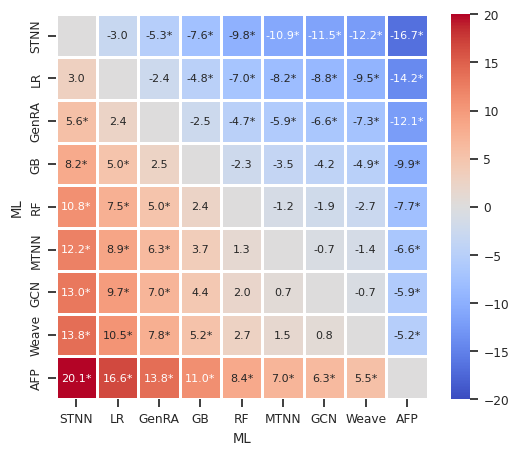

In [76]:
fig=pl.figure(figsize=(6,5))
ax=pl.subplot(1,1,1)
sns.heatmap(X0,vmin=-20,fmt='s',vmax=20,lw=1,
            annot=X,
            annot_kws=dict(fontsize=8),
            cmap='coolwarm',ax=ax)

# Leverage scores

In [95]:
DAT = '/home/ishah/ipynb/ml-tox/data/outputs/ATG/'


In [96]:
!ls $DAT
Pred0 = pd.read_csv(DAT+'TSCA_342_Attentive_FP_Predictions.csv',index_col=None).drop('Unnamed: 0',axis=1)
Lev0 = pd.read_csv(DAT+'TSCA_342_Attentive_FP_Predictions_Leverage_scores.csv',index_col=None).drop('Unnamed: 0',axis=1)
#        .melt(id_vars='DTXSID',var_name='assay',value_name='leverage')

TSCA_342_Attentive_FP_Predictions.csv
TSCA_342_Attentive_FP_Predictions_Leverage_scores.csv


In [97]:
Pred0.head()

,DTXSID,probability active,assay,predicted label,probability label,comp-1,comp-2,distance neighbor 1,train index neighbor 1,train dtxsid neighbor 1,...,train dtxsid neighbor 4,train label neighbor 4,comp-1 neighbor 4,comp-2 neighbor 4,distance neighbor 5,train index neighbor 5,train dtxsid neighbor 5,train label neighbor 5,comp-1 neighbor 5,comp-2 neighbor 5
0,DTXSID7059777,0.071117,ATG_AP_1_CIS,0,0.928883,46.039525,-0.081842,0.678796,1362,DTXSID4047620,...,DTXSID6052291,0,45.290574,-1.628464,1.187208,1155,DTXSID4022107,0,45.191799,-1.544702
1,DTXSID8061719,0.194838,ATG_AP_1_CIS,0,0.805162,11.163211,-20.323802,1.655027,829,DTXSID2051631,...,DTXSID1027558,0,12.598171,-15.269195,1.804493,2469,DTXSID8047000,1,13.151295,-21.787267
2,DTXSID1062752,0.306678,ATG_AP_1_CIS,0,0.693322,7.965793,-19.384579,1.720832,1057,DTXSID3044910,...,DTXSID7052109,1,14.028738,-22.038695,2.305191,2593,DTXSID9024431,0,12.930287,-20.878208
3,DTXSID1062178,0.060952,ATG_AP_1_CIS,0,0.939048,50.218914,-3.218433,0.759688,262,DTXSID0051736,...,DTXSID9040342,0,50.871291,-2.454063,1.105101,1088,DTXSID3047716,0,50.352979,-3.054109
4,DTXSID8059390,0.060146,ATG_AP_1_CIS,0,0.939854,60.767505,-8.899471,1.091561,2093,DTXSID7027596,...,DTXSID4029359,0,60.837701,-8.520781,1.315994,309,DTXSID1021164,0,59.784013,-8.847010


In [98]:
'DTXSID9047203' in Pred0.DTXSID,\
'DTXSID9022445' in Pred0.DTXSID

(False, False)

In [97]:
Lev0.columns

Index(['DTXSID', 'ATG_AP_1_CIS', 'ATG_AP_2_CIS', 'ATG_AR_TRANS', 'ATG_Ahr_CIS',
       'ATG_BRE_CIS', 'ATG_CAR_TRANS', 'ATG_CMV_CIS', 'ATG_CRE_CIS',
       'ATG_C_EBP_CIS', 'ATG_DR4_LXR_CIS', 'ATG_DR5_RAR_CIS', 'ATG_E2F_CIS',
       'ATG_EGR_CIS', 'ATG_ERE_CIS', 'ATG_ERRa_TRANS', 'ATG_ERRg_TRANS',
       'ATG_ERa_TRANS', 'ATG_E_Box_CIS', 'ATG_Ets_CIS', 'ATG_FXR_TRANS',
       'ATG_FoxA2_CIS', 'ATG_FoxO_CIS', 'ATG_GAL4_TRANS', 'ATG_GATA_CIS',
       'ATG_GLI_CIS', 'ATG_GRE_CIS', 'ATG_GR_TRANS', 'ATG_HIF1a_CIS',
       'ATG_HNF4a_TRANS', 'ATG_HNF6_CIS', 'ATG_HSE_CIS', 'ATG_IR1_CIS',
       'ATG_ISRE_CIS', 'ATG_LXRa_TRANS', 'ATG_LXRb_TRANS', 'ATG_MRE_CIS',
       'ATG_M_06_CIS', 'ATG_M_06_TRANS', 'ATG_M_19_CIS', 'ATG_M_19_TRANS',
       'ATG_M_32_CIS', 'ATG_M_32_TRANS', 'ATG_M_61_CIS', 'ATG_M_61_TRANS',
       'ATG_Myb_CIS', 'ATG_Myc_CIS', 'ATG_NFI_CIS', 'ATG_NF_kB_CIS',
       'ATG_NRF1_CIS', 'ATG_NRF2_ARE_CIS', 'ATG_NURR1_TRANS',
       'ATG_Oct_MLP_CIS', 'ATG_PBREM_CIS', 'ATG_PPARa_TRA

In [98]:
Pred0.head()

,DTXSID,probability active,assay,predicted label,probability label,comp-1,comp-2,distance neighbor 1,train index neighbor 1,train dtxsid neighbor 1,...,train dtxsid neighbor 4,train label neighbor 4,comp-1 neighbor 4,comp-2 neighbor 4,distance neighbor 5,train index neighbor 5,train dtxsid neighbor 5,train label neighbor 5,comp-1 neighbor 5,comp-2 neighbor 5
0,DTXSID7059777,0.071117,ATG_AP_1_CIS,0,0.928883,46.039525,-0.081842,0.678796,1362,DTXSID4047620,...,DTXSID6052291,0,45.290574,-1.628464,1.187208,1155,DTXSID4022107,0,45.191799,-1.544702
1,DTXSID8061719,0.194838,ATG_AP_1_CIS,0,0.805162,11.163211,-20.323802,1.655027,829,DTXSID2051631,...,DTXSID1027558,0,12.598171,-15.269195,1.804493,2469,DTXSID8047000,1,13.151295,-21.787267
2,DTXSID1062752,0.306678,ATG_AP_1_CIS,0,0.693322,7.965793,-19.384579,1.720832,1057,DTXSID3044910,...,DTXSID7052109,1,14.028738,-22.038695,2.305191,2593,DTXSID9024431,0,12.930287,-20.878208
3,DTXSID1062178,0.060952,ATG_AP_1_CIS,0,0.939048,50.218914,-3.218433,0.759688,262,DTXSID0051736,...,DTXSID9040342,0,50.871291,-2.454063,1.105101,1088,DTXSID3047716,0,50.352979,-3.054109
4,DTXSID8059390,0.060146,ATG_AP_1_CIS,0,0.939854,60.767505,-8.899471,1.091561,2093,DTXSID7027596,...,DTXSID4029359,0,60.837701,-8.520781,1.315994,309,DTXSID1021164,0,59.784013,-8.847010


In [99]:
Lev0.head()

,DTXSID,ATG_AP_1_CIS,ATG_AP_2_CIS,ATG_AR_TRANS,ATG_Ahr_CIS,ATG_BRE_CIS,ATG_CAR_TRANS,ATG_CMV_CIS,ATG_CRE_CIS,ATG_C_EBP_CIS,...,ATG_TAL_CIS,ATG_TA_CIS,ATG_TCF_b_cat_CIS,ATG_TGFb_CIS,ATG_THRa1_TRANS,ATG_VDRE_CIS,ATG_VDR_TRANS,ATG_Xbp1_CIS,ATG_p53_CIS,Leverage
0,DTXSID7059777,0.071117,0.050704,0.018704,0.257842,0.052559,0.051841,0.075085,0.073699,0.054118,...,0.055033,0.032112,0.081069,0.141111,0.049713,0.084202,0.052240,0.062665,0.094737,0.068234
1,DTXSID8061719,0.194838,0.125464,0.033180,0.358832,0.196669,0.075434,0.128522,0.251849,0.241039,...,0.125016,0.076330,0.132566,0.216592,0.079466,0.207402,0.067878,0.192767,0.193423,0.067350
2,DTXSID1062752,0.306678,0.101764,0.046402,0.422474,0.248814,0.061411,0.094624,0.285456,0.230943,...,0.143869,0.069204,0.225375,0.175601,0.095740,0.234609,0.043940,0.177684,0.377591,0.140955
3,DTXSID1062178,0.060952,0.049627,0.017101,0.248597,0.044468,0.061460,0.062141,0.074705,0.047602,...,0.064479,0.036885,0.085882,0.208139,0.044768,0.088277,0.040507,0.059201,0.097284,0.047783
4,DTXSID8059390,0.060146,0.014959,0.055736,0.241900,0.035847,0.068445,0.038180,0.052197,0.044476,...,0.048145,0.046566,0.102425,0.139480,0.050364,0.087682,0.022306,0.032613,0.108795,0.084471


In [100]:
Pred1 = Pred0.merge(Lev0[['DTXSID','Leverage']],on=['DTXSID']).reset_index().drop('index',axis=1)
Pred1.columns=Pred1.columns.str.replace('\W+','_').str.lower()
Pred1.loc[:,'leverage']=Pred1.leverage.astype(np.float)



/tmp/ipykernel_8886/1153106444.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  Pred1.columns=Pred1.columns.str.replace('\W+','_').str.lower()
/tmp/ipykernel_8886/1153106444.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Pred1.loc[:,'leverage']=Pred1.leverage.astype(np.float)


In [101]:
from scipy.stats import gaussian_kde

P = Pred1[Pred1.assay=='ATG_ERa_TRANS']
#P[(P.probability_active>0.8) & (P.leverage>0.18)]
P[(P.probability_active>0.8)]


,dtxsid,probability_active,assay,predicted_label,probability_label,comp_1,comp_2,distance_neighbor_1,train_index_neighbor_1,train_dtxsid_neighbor_1,...,train_label_neighbor_4,comp_1_neighbor_4,comp_2_neighbor_4,distance_neighbor_5,train_index_neighbor_5,train_dtxsid_neighbor_5,train_label_neighbor_5,comp_1_neighbor_5,comp_2_neighbor_5,leverage
6415,DTXSID0059665,0.834485,ATG_ERa_TRANS,1,0.834485,-18.240034,15.249995,4.378927e-02,2696,DTXSID9044164,...,1,-19.115910,15.995855,1.222604,671,DTXSID2026529,1,-19.115896,15.995730,0.022206
7144,DTXSID9059622,0.804883,ATG_ERa_TRANS,1,0.804883,-42.069549,-12.037766,1.169913e+00,303,DTXSID1021031,...,1,-36.061384,-6.050376,1.377667,1837,DTXSID6037728,1,-34.601416,-7.751550,0.028841
9250,DTXSID2058837,0.822536,ATG_ERa_TRANS,1,0.822536,-19.186446,18.319543,6.083117e-01,1281,DTXSID4041232,...,1,-19.811797,19.219331,1.036985,2136,DTXSID7035272,1,-19.884227,18.333869,0.030112
10303,DTXSID9074642,0.815818,ATG_ERa_TRANS,1,0.815818,-31.792052,23.248064,1.187001e+00,1486,DTXSID5024687,...,1,-30.710951,24.950519,1.289552,2154,DTXSID7040788,1,-20.740188,16.550021,0.017241
11761,DTXSID7052153,0.817310,ATG_ERa_TRANS,1,0.817310,-20.095457,19.603200,2.583868e-01,500,DTXSID1044518,...,1,-19.648226,19.498830,0.825806,215,DTXSID0047113,1,-20.230398,20.110794,0.029811
12004,DTXSID0064046,0.855946,ATG_ERa_TRANS,1,0.855946,-32.626662,27.568630,1.430317e-04,673,DTXSID2026602,...,1,-33.071478,27.694934,0.492529,482,DTXSID1041502,0,-33.104703,27.708700,0.023134
12085,DTXSID9061835,0.849772,ATG_ERa_TRANS,1,0.849772,-23.619405,24.325665,6.128080e-01,1780,DTXSID6025648,...,1,-17.374958,12.105949,1.226675,552,DTXSID1049697,1,-24.523137,25.071358,0.027018
13138,DTXSID2020216,0.847228,ATG_ERa_TRANS,1,0.847228,-33.064776,27.701896,3.371748e-07,565,DTXSID2020216,...,0,-32.635849,27.595633,0.504627,1790,DTXSID6027052,1,-32.576218,27.566570,0.025780
14596,DTXSID50888739,0.811350,ATG_ERa_TRANS,1,0.811350,-32.380536,27.492208,1.035177e+00,2570,DTXSID9022360,...,0,-31.947453,27.918689,1.256885,565,DTXSID2020216,1,-33.071478,27.694934,0.031303
16216,DTXSID20957284,0.832979,ATG_ERa_TRANS,1,0.832979,-31.846738,27.866458,7.106765e-01,1370,DTXSID4048193,...,1,-32.288653,27.360639,1.345864,1790,DTXSID6027052,1,-32.576218,27.566570,0.038019


In [102]:
l0 = 3*(167+1)/2773

N = len(Pred1.dtxsid.unique())

Res = []
for p0,l1 in [(i,j) for i in [0.5,0.6,0.7,0.8] for j in [l0,2*l0,3*l0]]:
    Pi = Pred1[(Pred1.leverage<=l1) & (Pred1.probability_label>=p0)]
    #Ri = Pi.groupby(['assay','predicted_label']).aggregate(dict(dtxsid=len)).reset_index()\
    #        .rename(columns=dict(dtxsid='n'))
    #Ri.insert(1,'prob',p0)
    Ri = Pi.pivot_table(index=['assay'],columns=['predicted_label'],values='dtxsid',
                        aggfunc=len,fill_value=0)\
            .rename(columns={0:'n_neg',1:'n_pos'})
            #.drop('predicted_label',axis=1)
    Ri = Ri.join(pd.DataFrame(dict(p0=p0,l0=l1,n=N),index=Ri.index))
    Res.append(Ri)

Pred2 = pd.concat(Res).reset_index()


In [103]:
Pred2[Pred2.assay=='ATG_ERa_TRANS']

,assay,n_neg,n_pos,p0,l0,n
16,ATG_ERa_TRANS,191,110,0.5,0.181753,342
97,ATG_ERa_TRANS,212,117,0.5,0.363505,342
178,ATG_ERa_TRANS,219,118,0.5,0.545258,342
259,ATG_ERa_TRANS,160,75,0.6,0.181753,342
340,ATG_ERa_TRANS,177,78,0.6,0.363505,342
421,ATG_ERa_TRANS,183,78,0.6,0.545258,342
502,ATG_ERa_TRANS,137,35,0.7,0.181753,342
583,ATG_ERa_TRANS,152,36,0.7,0.363505,342
664,ATG_ERa_TRANS,156,36,0.7,0.545258,342
745,ATG_ERa_TRANS,115,13,0.8,0.181753,342


In [104]:
#SelAssay2 = [i for i in SelAssay if i.find('TRANS')>-1]

R=Pred2[(Pred2.l0<0.2) & Pred2.assay.str.contains('TRANS')]\
    .pivot_table(index=['assay'],
                  columns='p0',
                  values='n_pos')\
    .sort_values(0.5,ascending=False)
R.loc[R[0.5]>0]

p0,0.5,0.6,0.7,0.8
assay,,,,
ATG_PXR_TRANS,144,121,86,43
ATG_PPARg_TRANS,136,104,72,36
ATG_ERa_TRANS,110,75,35,13
ATG_RXRb_TRANS,58,36,16,1
ATG_RARa_TRANS,50,2,0,0
ATG_PPARa_TRANS,21,5,2,0
ATG_CAR_TRANS,8,0,0,0
ATG_RARg_TRANS,4,0,0,0


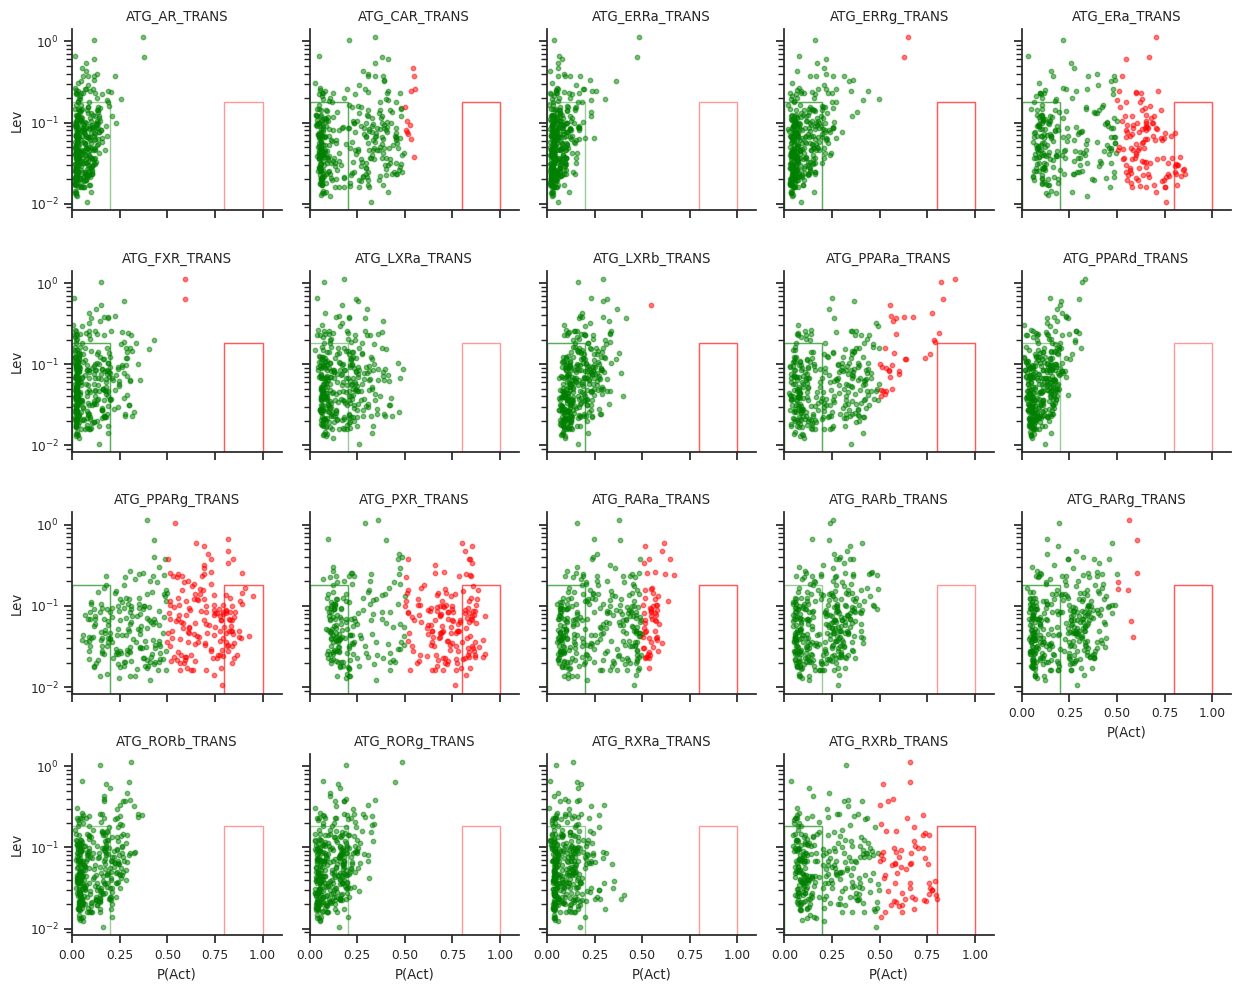

In [105]:
import seaborn as sns
import matplotlib.patches as patches
import pylab as pl 
l0 = 3*(167+1)/2773
SelAssay2 = [i for i in SelAssay if i.find('TRANS')>-1]
Pred2 = Pred1[Pred1.assay.isin(SelAssay2)].dropna()
sns.set(font_scale=0.8,style='ticks')

R1 = [0,0.2,0,l0]
R2 = [0.8,1,0,l0]

def highlight_square(X,Y, **kws):
    ax = pl.gca()
    x1,x2,y1,y2 = kws['rect']
    lw=kws['lw']
    alpha=kws['alpha']
    color=kws['color']
    fill=kws['fill']
    
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=lw, edgecolor=color, 
                             facecolor=color if fill else 'none',alpha=alpha)    
    ax.add_patch(rect)
    # n_pos,n_neg=5,10
    # ax.annotate(r"$n_p$={}\n$n_n$={}".format(n_pos,n_neg),
    #             xy=(.8, 1), size=10,
    #             xycoords=ax.transAxes)

    
g=sns.FacetGrid(Pred2,col='assay',col_wrap=5,
                height=2.5,aspect=1,
                hue='predicted_label',
                palette={0:'green',1:'red'},
                legend_out=True)
A,B = 'probability_active','leverage'
g.map(pl.scatter,A,B,s=10,alpha=0.5)
g.map(highlight_square,A,B,color='red',rect=R2,lw=1,alpha=0.4,fill=False)
g.map(highlight_square,A,B,color='green',rect=R1,lw=1,alpha=0.4,fill=False)
#g.map(sns.swarmplot,A,B,s=15,alpha=0.5)
#g.map(corrfunc,A,B)
#g.map(mr2_score,A,B)
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='blue')#,linestyle='--')#,linewidth=0.5,color='grey')
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='blue')#,linestyle='--')#,linewidth=0.5,color='grey')
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='orange')#,linestyle='--')#,linewidth=0.5,color='grey')


g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.set(xlabel=r'P(Act)',
      yscale='log',
      xlim=[0,1.1],
      ylabel=r'Lev')

g.fig.tight_layout()


In [58]:
Pred2[Pred2.p0==0.8].sort_values('n_pos',ascending=False)

,n_neg,n_pos,p0,l0,n
assay,,,,,
ATG_PXRE_CIS,0,135,0.8,0.181753,342
ATG_NRF2_ARE_CIS,23,94,0.8,0.181753,342
ATG_PXR_TRANS,90,43,0.8,0.181753,342
ATG_PPARg_TRANS,52,36,0.8,0.181753,342
ATG_ERE_CIS,52,16,0.8,0.181753,342
...,...,...,...,...,...
ATG_HNF6_CIS,167,0,0.8,0.181753,342
ATG_HNF4a_TRANS,258,0,0.8,0.181753,342
ATG_GR_TRANS,280,0,0.8,0.181753,342


In [208]:
Pred1[(Pred1.assay=='ATG_PPARA_TRANS') & (Pred1.predicted_label==1) & (Pred1.leverage<0.5) ]

,dtxsid,probability_active,assay,predicted_label,probability_label,comp_1,comp_2,distance_neighbor_1,train_index_neighbor_1,train_dtxsid_neighbor_1,...,train_label_neighbor_4,comp_1_neighbor_4,comp_2_neighbor_4,distance_neighbor_5,train_index_neighbor_5,train_dtxsid_neighbor_5,train_label_neighbor_5,comp_1_neighbor_5,comp_2_neighbor_5,leverage


# Blind predictions

In [158]:
PMI = pd.read_csv('~/ipynb/httr-epa/data/inputs/heparg/heparg-chm-gene-npmi.tsv.gz',sep='\t')
PMI.columns = PMI.columns.str.lower()
PMI.rename(columns={k:k.replace('srp','gene') for k in PMI.columns},inplace=True)

In [159]:
PMI

,chemical,gene,cooccurrence,max_pmi_gene,chemical_count,gene_count,total_db,freq_chemical,freq_search,freq_coocurrence,pmi,dtxsid,npmi
0,"1,2-diphenylethanedione",A2M,755,RDH14,13117250,1191,33000000,0.397492,3.609091e-05,0.000023,0.673376,DTXSID3044380,0.043681
1,"1,2-diphenylethanedione",ABAT,148,RDH14,13117250,313,33000000,0.397492,9.484848e-06,0.000004,0.250435,DTXSID3044380,0.014096
2,"1,2-diphenylethanedione",ABCA1,3716,RDH14,13117250,4460,33000000,0.397492,1.351515e-04,0.000113,1.067384,DTXSID3044380,0.081402
3,"1,2-diphenylethanedione",ABCB1,5417,RDH14,13117250,7122,33000000,0.397492,2.158182e-04,0.000164,0.935605,DTXSID3044380,0.074464
4,"1,2-diphenylethanedione",ABCB11,506,RDH14,13117250,912,33000000,0.397492,2.763636e-05,0.000015,0.481104,DTXSID3044380,0.030082
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940663,"2,4-dinitrotoluene",ZSCAN9,0,NAT1,627,3,33000000,0.000019,9.090909e-08,0.000000,-9999.000000,DTXSID0020529,-1.000000
3940664,"2,4-dinitrotoluene",ZXDA,0,NAT1,627,14,33000000,0.000019,4.242424e-07,0.000000,-9999.000000,DTXSID0020529,-1.000000
3940665,"2,4-dinitrotoluene",ZXDB,0,NAT1,627,6,33000000,0.000019,1.818182e-07,0.000000,-9999.000000,DTXSID0020529,-1.000000
3940666,"2,4-dinitrotoluene",ZXDC,0,NAT1,627,11,33000000,0.000019,3.333333e-07,0.000000,-9999.000000,DTXSID0020529,-1.000000


In [144]:
Blind=pd.read_csv("/home/ishah/Downloads/blind_DTX_ATG_Attentive_FP.csv").drop('Unnamed: 0',axis=1)\
            .rename(columns=dict(target='gene'))
Blind.columns=Blind.columns.str.replace('\s+','_').str.lower()


/tmp/ipykernel_15586/3963662151.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  Blind.columns=Blind.columns.str.replace('\s+','_').str.lower()


In [145]:
Blind

,dtxsid,assay_component_name,gene,target_active_prob,leverage,in_training_set
0,DTXSID0059794,ATG_GPCR_ADORA2A_TRANS,ADORA2A,NaN,0.249313,0
1,DTXSID5058773,ATG_GPCR_ADORA2A_TRANS,ADORA2A,NaN,0.053197,0
2,DTXSID0020232,ATG_GPCR_ADORA2A_TRANS,ADORA2A,NaN,0.091068,1
3,DTXSID6021248,ATG_GPCR_ADORA2A_TRANS,ADORA2A,NaN,0.050881,1
4,DTXSID6034972,ATG_GPCR_ADORA2A_TRANS,ADORA2A,NaN,0.016540,1
...,...,...,...,...,...,...
3036,DTXSID2020341,ATG_VDR_TRANS,VDR,0.170725,0.034032,0
3037,DTXSID2043874,ATG_VDRE_CIS,VDR,0.150130,0.046211,0
3038,DTXSID2043874,ATG_VDR_TRANS,VDR,0.029517,0.046167,0
3039,DTXSID3022958,ATG_VDRE_CIS,VDR,0.719833,0.063775,0


In [160]:
BLND_PMI = PMI.merge(Blind,on=['dtxsid','gene'])

In [147]:
BLND_PMI.head()

,chemical,gene,cooccurrence,max_pmi_gene,chemical_count,gene_count,total_db,freq_chemical,freq_search,freq_coocurrence,pmi,dtxsid,assay_component_name,target_active_prob,leverage,in_training_set
0,9-chloro-perfluorononanoic acid,RARA,2013,THAP6,3339578,4312,33000000,0.101199,0.000131,0.000061,2.205384,DTXSID30382104,ATG_RARa_TRANS,0.415689,0.086451,0
1,9-chloro-perfluorononanoic acid,RORC,404,THAP6,3339578,1246,33000000,0.101199,0.000038,0.000012,1.679851,DTXSID30382104,ATG_RORE_CIS,0.402347,0.086453,0
2,9-chloro-perfluorononanoic acid,RORC,404,THAP6,3339578,1246,33000000,0.101199,0.000038,0.000012,1.679851,DTXSID30382104,ATG_RORg_TRANS,0.390787,0.086448,0
3,9-chloro-perfluorononanoic acid,SP1,3880,THAP6,3339578,13922,33000000,0.101199,0.000422,0.000118,1.460454,DTXSID30382104,ATG_Sp1_CIS,0.513384,0.086454,0
4,4h-perfluorobutanoic acid,RARA,2013,THAP6,3339578,4312,33000000,0.101199,0.000131,0.000061,2.205384,DTXSID50892417,ATG_RARa_TRANS,0.121127,0.082206,0


In [161]:
BLND_PMI[BLND_PMI.gene=='ESR1'].shape

(168, 17)

In [150]:
BLND_PMI[BLND_PMI.in_training_set==0].gene.value_counts()

NR1I2      94
MYC        89
AHR        78
ESR1       76
STAT3      75
TP53       67
HIF1A      58
VDR        52
GNAS       50
SP1        45
RORC       44
NFE2L2     43
EGR1       42
PPARG      40
NR1H3      40
NR1I3      40
TGFB1      39
NR3C1      32
RARA       30
PGR        28
FOXO3      27
E2F1       24
PPARA      23
NFKB1      22
DRD1       22
NRF1       21
RXRA       20
PPARD      20
SREBF1     20
NR4A3      20
NR4A2      19
ETS1       18
PTGIR      18
DRD5       18
NR1D1      17
NR4A1      17
FFAR1      16
HNF4A      16
GLI1       16
NR5A1      16
RARB       16
CEBPB      15
ADRB2      15
GPBAR1     14
USF1       14
RORA       12
ESR2       10
CHRM3      10
ADORA2A     7
THRB        7
Name: gene, dtype: int64

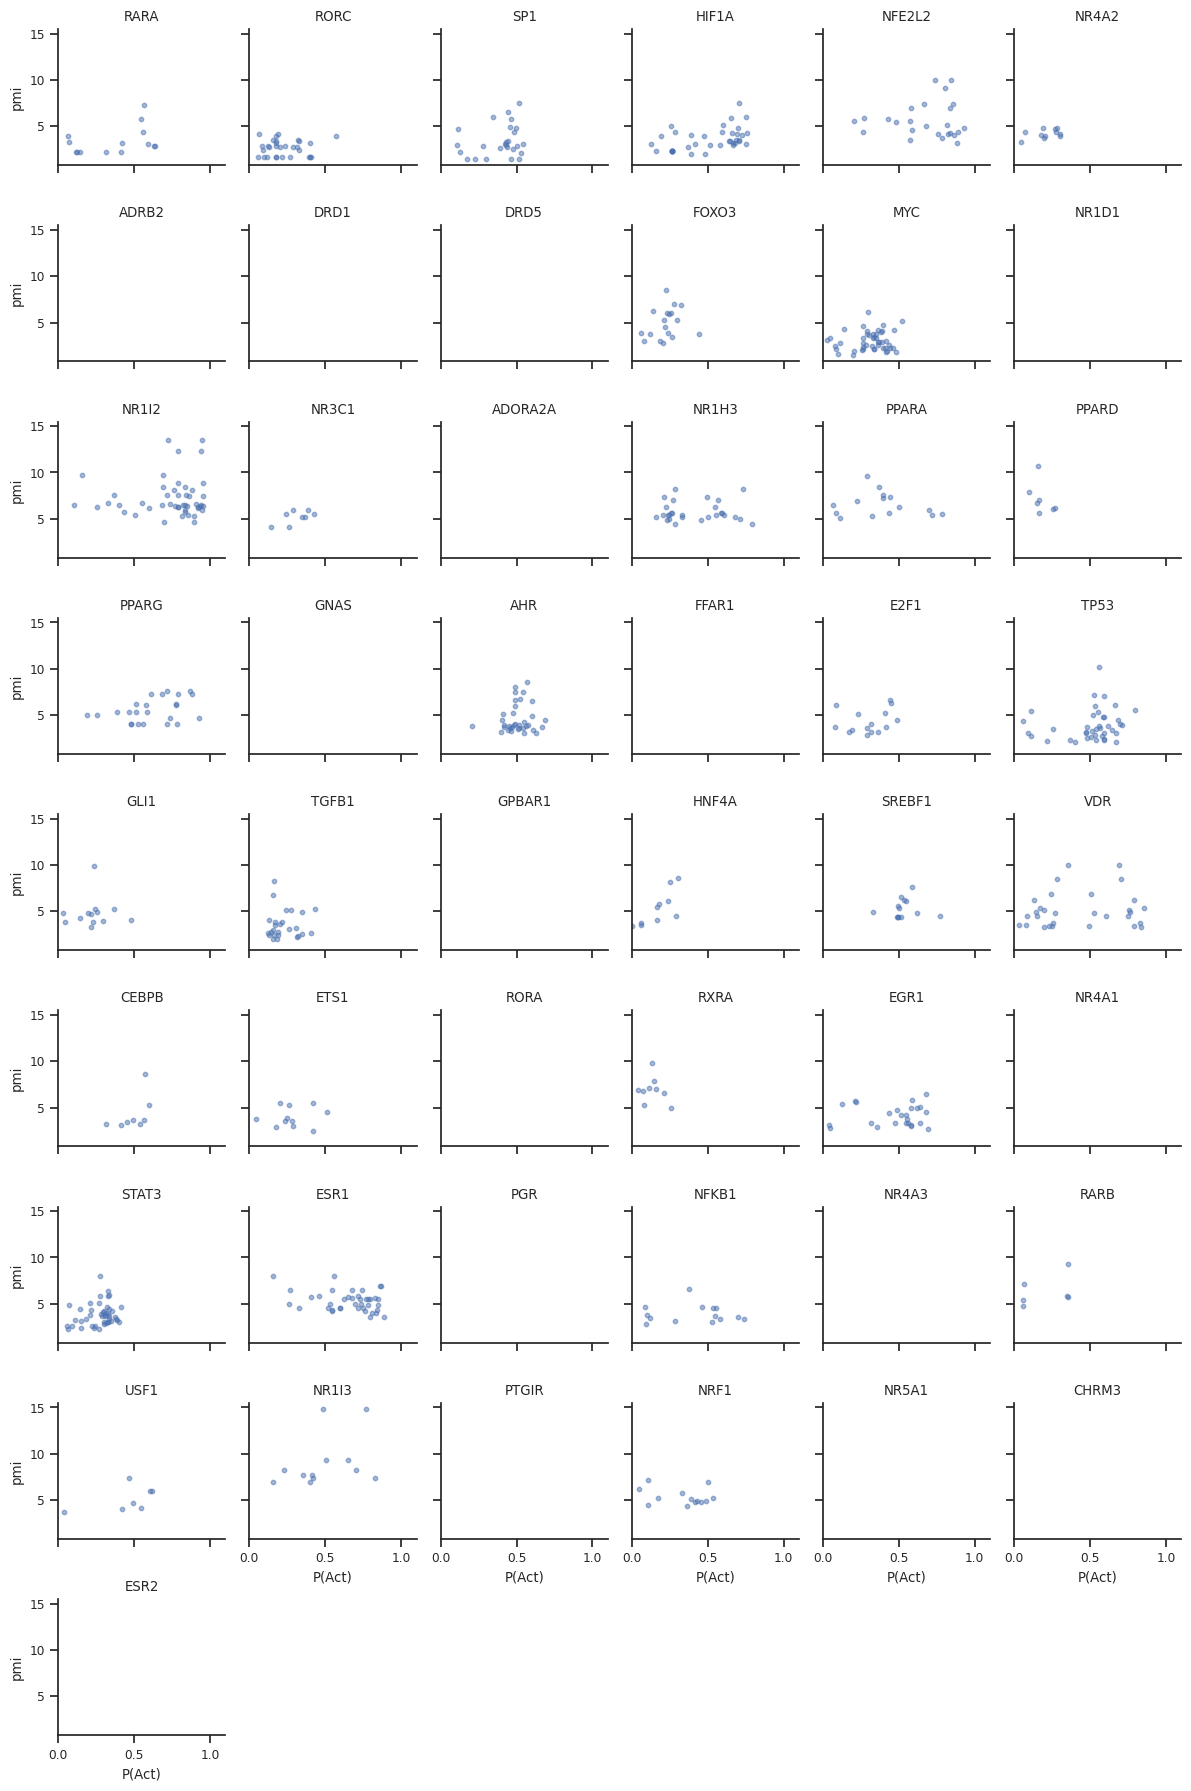

In [162]:
import seaborn as sns
import matplotlib.patches as patches
import pylab as pl 


sns.set(font_scale=0.8,style='ticks')

R1 = [0,0.2,0,l0]
R2 = [0.8,1,0,l0]

def highlight_square(X,Y, **kws):
    ax = pl.gca()
    x1,x2,y1,y2 = kws['rect']
    lw=kws['lw']
    alpha=kws['alpha']
    color=kws['color']
    fill=kws['fill']
    
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=lw, edgecolor=color, 
                             facecolor=color if fill else 'none',alpha=alpha)    
    ax.add_patch(rect)
    # n_pos,n_neg=5,10
    # ax.annotate(r"$n_p$={}\n$n_n$={}".format(n_pos,n_neg),
    #             xy=(.8, 1), size=10,
    #             xycoords=ax.transAxes)

    
g=sns.FacetGrid(BLND_PMI[(BLND_PMI.pmi>-10) & (BLND_PMI.in_training_set==0)],
                col='gene',col_wrap=6,
                height=2,aspect=1,
                #hue='leverage',
                palette={0:'green',1:'red'},
                legend_out=True)
A,B = 'target_active_prob','pmi'
g.map(pl.scatter,A,B,s=10,alpha=0.5)
g.map(highlight_square,A,B,color='red',rect=R2,lw=1,alpha=0.4,fill=False)
#g.map(highlight_square,A,B,color='green',rect=R1,lw=1,alpha=0.4,fill=False)
#g.map(sns.swarmplot,A,B,s=15,alpha=0.5)
#g.map(corrfunc,A,B)
#g.map(mr2_score,A,B)
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='blue')#,linestyle='--')#,linewidth=0.5,color='grey')
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='blue')#,linestyle='--')#,linewidth=0.5,color='grey')
#g.map_dataframe(pl.plot,[0,1],[0.17,0.17],'--',linewidth=1,color='orange')#,linestyle='--')#,linewidth=0.5,color='grey')


g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.set(xlabel=r'P(Act)',
      #yscale='log',
      xlim=[0,1.1],
      ylabel=r'pmi')

g.fig.tight_layout()
